In [1]:
import numpy as np
import copy
from qiskit import *
from qiskit.visualization import plot_histogram
from math import *
from qiskit.quantum_info import Pauli, state_fidelity, basis_state, process_fidelity
from qiskit.visualization import plot_bloch_vector
%matplotlib inline

In [2]:
def stater(qc):
    backend_sim = BasicAer.get_backend('statevector_simulator')
    result = execute(qc, backend_sim).result()
    state = result.get_statevector(qc)
    print(state)

original
[1.+0.j 0.+0.j]
insert h gate
[0.70710678+0.j 0.70710678+0.j]


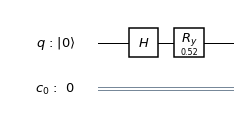

In [53]:
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
qc = QuantumCircuit(q, c)
print("original")
stater(qc)
print("insert h gate")
qc.h(q)
stater(qc)
qc.ry(pi/6,q)
'''
print("insert rz gate")
qc.rz(pi/6,q)
stater(qc)
print("insert ry gate")
qc.ry(pi/4,q)
stater(qc)
'''
qc.draw(output='mpl')

In [54]:
meas = QuantumCircuit(q,c)
meas.measure(q, c)

# execute the quantum circuit 
backend = BasicAer.get_backend('qasm_simulator') # the device to run on
circ = qc+meas
result = execute(circ, backend, shots=10000).result()
counts  = result.get_counts(circ)
print(counts)

{'1': 7470, '0': 2530}


In [55]:
# from https://quantumexperience.ng.bluemix.net/proxy/tutorial/full-user-guide/002-The_Weird_and_Wonderful_World_of_the_Qubit/005-The_Bloch_Sphere.html
meas_x = QuantumCircuit(q, c)
meas_x.h(q)
meas_x.measure(q, c)

meas_y = QuantumCircuit(q, c)
meas_y.s(q).inverse()
meas_y.h(q)
meas_y.measure(q, c)

meas_z = QuantumCircuit(q, c)
meas_z.measure(q, c)

bloch_vector = ['x', 'y', 'z']
exp_vector = range(0, 21)
circuits = []

for exp_index in exp_vector:
    middle = QuantumCircuit(q, c)
    phase = 2*np.pi*exp_index/(len(exp_vector)-1)
    middle.u1(phase, q)
    circuits.append(qc + middle + meas_x)
    circuits.append(qc + middle + meas_y)
    circuits.append(qc + middle + meas_z)
    
job = execute(circuits,
              backend = Aer.get_backend('qasm_simulator'),
              shots=1024)
result = job.result()

for exp_index in exp_vector:
    bloch = [0, 0, 0]
    for bloch_index in range(len(bloch_vector)):
        data = result.get_counts(circuits[3*exp_index+bloch_index])
        try:
            p0 = data['0']/1024.0
        except KeyError:
            p0 = 0
        try:
            p1 = data['1']/1024.0
        except KeyError:
            p1 = 0
        bloch[bloch_index] = p0-p1

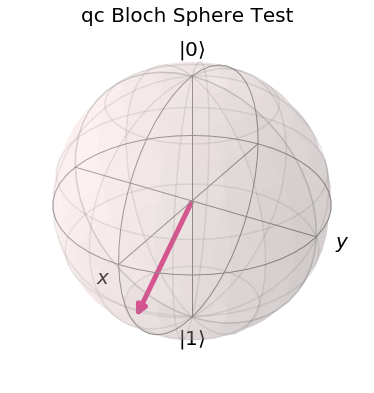

In [56]:
plot_bloch_vector(bloch, title='qc Bloch Sphere Test')
#this graph is the result of the qc circuit of one qubit

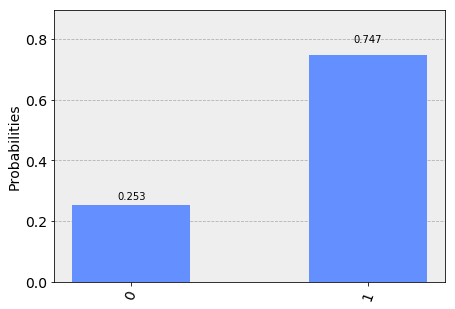

In [57]:
plot_histogram(counts)

In [58]:
a_counts=counts['0']/10000

In [59]:
alpha = np.arccos(a_counts)
print(alpha)

1.315016439662327


In [60]:
def executer(q,c,qc):
    meas = QuantumCircuit(q,c)
    meas.measure(q, c)
    backend = BasicAer.get_backend('qasm_simulator') # the device to run on
    circ = qc+meas
    result = execute(circ, backend, shots=10000).result()
    counts  = result.get_counts(circ)
    return counts

In [65]:
def componentFinder(qc):
    # x component
    x_finder = copy.deepcopy(qc)
    x_finder.ry(pi/2,q)
    if '0' not in executer(q,c,x_finder):
        counter = executer(q,c,x_finder)['1']
    else:
        counter = executer(q,c,x_finder)['0']
    x_counts = counter/10000
    one = np.arccos(x_counts)
    if x_counts < 0.5:
        one = -one
    print('x component =')
    print(one)
    # y component
    y_finder = copy.deepcopy(qc)
    y_finder.rx(pi/2,q)
    if '0' not in executer(q,c,y_finder):
        counter = executer(q,c,y_finder)['1']
    else:
        counter = executer(q,c,y_finder)['0']
    y_counts = counter/10000
    two = np.arccos(y_counts)
    if y_counts < 0.5:
        two = -two
    print('y component =')
    print(two)
    # z component
    z_finder = copy.deepcopy(qc)
    if '0' not in executer(q,c,z_finder):
        counter = executer(q,c,z_finder)['1']
    else:
        counter = executer(q,c,z_finder)['0']
    z_counts = counter/10000
    three = np.arccos(z_counts)
    if z_counts < 0.5:
        three = -three
    print('z component =')
    print(three)
    coordinate = [cos(one),-cos(two),cos(three)]
    print('returns coordinates of state vector (rcos(theta) of components)')
    print(coordinate)
    return coordinate

x component =
-1.505048969183208
y component =
-1.0476593698607504
z component =
-1.3202843370810045
returns coordinates of state vector (rcos(theta) of components)
[0.0657, -0.4995999999999999, 0.24790000000000012]


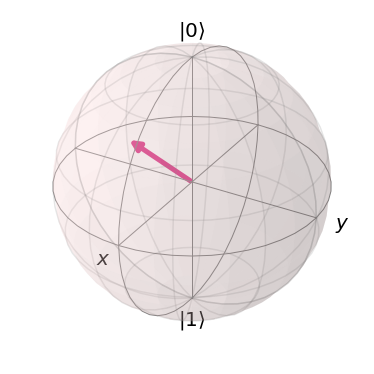

In [66]:
coordinate = componentFinder(qc)
plot_bloch_vector(coordinate)